# Word Prediction using Recurrent Neural Networks (RNNs)
## Experiment 2016-12-23

Loop over training size, plot learning curves. 

### Table of Contents

1. Prepare Data
2. Explore Data
3. Analyze Models
4. Generate Text

## Imports

In [88]:
# import python modules
from __future__ import print_function, division
import os.path
import random
from nltk import tokenize

In [89]:
# import wp modules (can be slow)
import sys; sys.path.append('../../src')
print('importing wp (and nltk)...')
import wp
print('done')

importing wp (and nltk)...
done


In [90]:
# reload wp modules in case changed (for development purposes)
reload(wp)
reload(wp.data)
reload(wp.ngram)
reload(wp.rnn)
reload(wp.analyze)

<module 'wp.analyze' from '../../src\wp\analyze.py'>

## Initialize

In [91]:
random.seed(0)

## 1. Prepare Data

Merge raw text files, convert to plain strings, split into train, validate, and test sets.

In [92]:
# get wrapper around all data and tokenization
data = wp.data.Data()

Merge the raw data files into one and remove non-ascii characters (nltk complains otherwise).

In [93]:
data.merge()

The raw files have already been merged.


Split the merged file by sentences into train, validate, and test sets.

In [94]:
data.split()

The merged file has already been split.


## 2. Explore Data

### Show some samples of the text

In [95]:
s_merged = data.text('merged')
nsamples = 5
nchars = len(s_merged)
nskip = int(nchars / nsamples)
for i in range(nsamples):
    s = s_merged[i*nskip:i*nskip+200]
    s = s.replace('\n', ' ').strip()
    print(s)
    print()

The Project Gutenberg EBook of Phantastes, by George MacDonald  This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever.  You may copy it, give it away or re

to be vanquished, retreated; but Wellington shouted, "Up, Guards, and aim straight!" The red regiment of English guards, lying flat behind the hedges, sprang up, a cloud of grape-shot riddled the tric

xcept that geometrical point, the _I_; bringing everything back to the soul-atom; expanding everything in God, entangling all activity, from summit to base, in the obscurity of a dizzy mechanism, atta

y, or to speak more accurately, that same evening, as Marius left the table, and was on the point of withdrawing to his study, having a case to look over, Basque handed him a letter saying: "The perso

ay evening in January, the lonely valley had been a desirable place to him; he had watched the green battlements in summer and winter weather, had seen the heaped mounds rising dimly amidst th

### Show some text split into sentences

This shows how the text was split up into the train, validate, and test sets.

In [96]:
# we'll just look at the first 50k characters, because parsing sentences is slow
sentences = data.sentences('merged', 50000)
random.seed(0)
samples = random.sample(sentences, 5)
print('\n\n'.join(samples))

And off they set, after some new mischief.

Primrose is gone.

But how then do you come to live here?

He looked up, and lo!

It contained many wondrous tales of Fairy Land, and olden times, and the Knights of King Arthurs table.


### Show the text split into tokens

Note that punctuation marks are treated as separate tokens.

In [97]:
tokens = data.tokens('merged', 50000) # look at first 50k characters
print('ntokens',len(tokens))
print(tokens[8000:8100])

ntokens 10369
[';', 'as', 'if', 'we', 'were', 'not', 'good', 'enough', 'to', 'look', 'at', 'her', ',', 'and', 'she', 'was', ',', 'the', 'proud', 'thing', '!', '--', 'served', 'her', 'right', '!', 'Oh', ',', 'Pocket', ',', 'Pocket', ',', 'said', 'I', ';', 'but', 'by', 'this', 'time', 'the', 'party', 'which', 'had', 'gone', 'towards', 'the', 'house', ',', 'rushed', 'out', 'again', ',', 'shouting', 'and', 'screaming', 'with', 'laughter', '.', 'Half', 'of', 'them', 'were', 'on', 'the', 'cats', 'back', ',', 'and', 'half', 'held', 'on', 'by', 'her', 'fur', 'and', 'tail', ',', 'or', 'ran', 'beside', 'her', ';', 'till', ',', 'more', 'coming', 'to', 'their', 'help', ',', 'the', 'furious', 'cat', 'was', 'held', 'fast', ';', 'and', 'they', 'proceeded']


## 3. Analyze Models

Train models on the training tokens and test them on the test tokens.

In [98]:
# define models to test
model_list = [
    [wp.ngram.NgramModel, {'n':2}],
    [wp.ngram.NgramModel, {'n':3}],
    [wp.ngram.NgramModel, {'n':4}],
    #[wp.rnn.RnnModel, {}],
]

In [99]:
nchars_list = (1000,10000,100000,1000000,6000000)
rows = []
for nchars in nchars_list:
    print(nchars)
    models = wp.analyze.train_models(model_list, data, nchars)
    results = wp.analyze.test_models(models, data, nchars)
    print()
    row = [nchars] + results
    rows.append(row)

1000
load model: models/NgramModel-(nchars-1000,n-2).pickle
load model: models/NgramModel-(nchars-1000,n-3).pickle
load model: models/NgramModel-(nchars-1000,n-4).pickle
done
n-gram (n=2)
nright/total=1/1000 = 0.001000

n-gram (n=3)
nright/total=0/1000 = 0.000000

n-gram (n=4)
nright/total=0/1000 = 0.000000


10000
load model: models/NgramModel-(nchars-10000,n-2).pickle
load model: models/NgramModel-(nchars-10000,n-3).pickle
load model: models/NgramModel-(nchars-10000,n-4).pickle
done
n-gram (n=2)
nright/total=99/1000 = 0.099000

n-gram (n=3)
nright/total=13/1000 = 0.013000

n-gram (n=4)
nright/total=3/1000 = 0.003000


100000
load model: models/NgramModel-(nchars-100000,n-2).pickle
load model: models/NgramModel-(nchars-100000,n-3).pickle
load model: models/NgramModel-(nchars-100000,n-4).pickle
done
n-gram (n=2)
nright/total=190/1000 = 0.190000

n-gram (n=3)
nright/total=85/1000 = 0.085000

n-gram (n=4)
nright/total=14/1000 = 0.014000


1000000
load model: models/NgramModel-(nchars-100

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

cols = ['nchars'] + [model.name for model in models]
df = pd.DataFrame(rows, columns=cols)
df

,nchars,n-gram (n=2),n-gram (n=3),n-gram (n=4)
0,1000,0.001,0.000,0.000
1,10000,0.099,0.013,0.003
2,100000,0.190,0.085,0.014
3,1000000,0.234,0.133,0.036
4,6000000,0.239,0.176,0.053


In [106]:
dft = df.transpose()
dft.columns = nchars_list
dft2 = dft.drop('nchars',axis=0)
dft2

,1000,10000,100000,1000000,6000000
n-gram (n=2),0.001,0.099,0.190,0.234,0.239
n-gram (n=3),0.000,0.013,0.085,0.133,0.176
n-gram (n=4),0.000,0.003,0.014,0.036,0.053


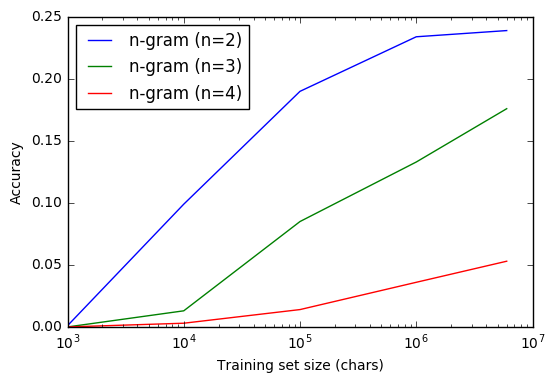

In [121]:
%matplotlib inline

plt.plot(dft2.columns, dft2.ix[0])
plt.plot(dft2.columns, dft2.ix[1])
plt.plot(dft2.columns, dft2.ix[2])
plt.legend(loc='best')
plt.xscale('log')
plt.xlabel('Training set size (chars)')
plt.ylabel('Accuracy')
plt.show()

## 4. Generate Text